In [1]:
! pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm
! pip install --upgrade pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: pydicom
    Found existing installation: pydicom 2.3.1
    Uninstalling pydicom-2.3.1:
      Successfully uninstalled pydicom-2.3.1


In [2]:
try:
    import pylibjpeg
except:
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

In [3]:
# basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.metrics import confusion_matrix
import random
from PIL import Image

# specific for medical image data
import pydicom
pydicom.__version__

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset

In [4]:
# the path to the image data
RSNA_2022_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'

In [5]:
# Read the csv data.
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [6]:
# the number of total patients
len(df_train)

54706

In [7]:
# the number of patients having implant
len(df_train[df_train['implant'] == 1])

1477

In [8]:
# the number of patients without malignant cancer
len(df_train[df_train['cancer'] == 0])

53548

In [9]:
# the number of patient who took biopsy
len(df_train[df_train['biopsy'] == 1])

2969

In [10]:
# the number of patients having malignant cancer
len(df_train[df_train['cancer'] == 1])

1158

In [11]:
# the number of patients whose malignant cancer is invasive
len(df_train[df_train['invasive'] == 1])

818

In [12]:
# the same as above
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])

818

<AxesSubplot:xlabel='class', ylabel='count'>

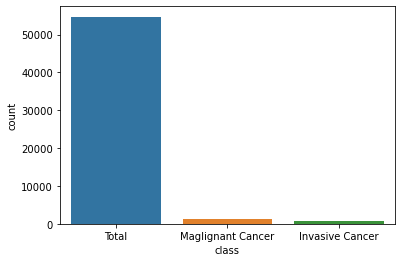

In [13]:
# Most of the cases are normal or not-malignant cancer. Thus, physicians sometimes overlook cancer.
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

<AxesSubplot:xlabel='class', ylabel='count'>

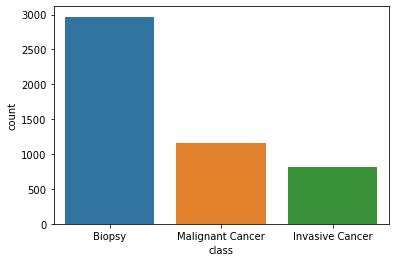

In [14]:
# Around 3000 patient took biopsy and malignant cancer was found from some of them.
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [15]:
# the number of not-malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1811

In [16]:
# the number of malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

1158

<AxesSubplot:xlabel='class', ylabel='count'>

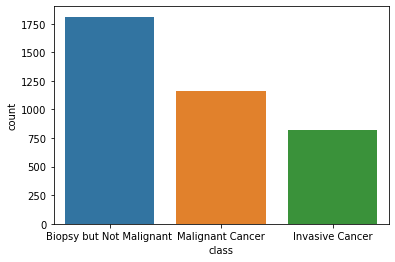

In [17]:
# 60% of biopsy resulted in not-malignanct cancer.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [18]:
# The not-malignant cancer cases were limited into biopsy cases. 
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [19]:
# The number of positive (malignant) and negative (not-malignat) cases should be the same
# to create a balanced dataset.
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<AxesSubplot:xlabel='class', ylabel='count'>

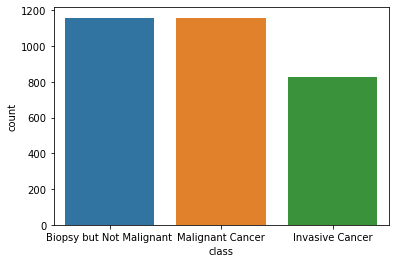

In [20]:
# Generally, invasive cancer is confirmed by biopsy, not by mammography.
# Maybe it is also extremely difficult for AI to detect invasive cancer from mammography.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [21]:
dcmfnm = '/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'

ds = pydicom.dcmread(dcmfnm, force = True)
print("Display Meta Information\n", ds)

# Get information with keyword.
p_id = ds.PatientID
print("\n>Patient ID=", p_id, type(p_id))

Display Meta Information
 Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0

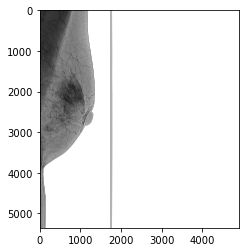

In [22]:
# This is the way to visualize a medical image.
img = ds.pixel_array
plt.imshow(img, cmap = 'gray')
plt.show()

In [23]:
img

array([[1803, 1845, 1874, ..., 3044, 3044, 3044],
       [1834, 1866, 1902, ..., 3044, 3044, 3044],
       [1866, 1894, 1903, ..., 3044, 3044, 3044],
       ...,
       [2250, 2259, 2240, ..., 3044, 3044, 3044],
       [2246, 2256, 2235, ..., 3044, 3044, 3044],
       [2196, 2217, 2226, ..., 3044, 3044, 3044]], dtype=uint16)

In [24]:
# The size of medical image is extremely huge.
img.shape

(5355, 4915)

In [25]:
# Take another image.
ds = pydicom.dcmread(os.path.join(RSNA_2022_path + '/' + str(DF_train.loc[0, 'patient_id']) + '/' + str(DF_train.loc[0, 'image_id']) + '.dcm'), force = True)
img = ds.pixel_array.astype(np.float32)
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
img.shape

(4096, 3328)

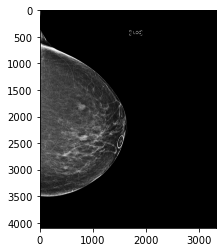

In [27]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [28]:
# The size of image must be resized to reduce computational costs for machine learning.
img = np.resize(img, (1024, 1024))

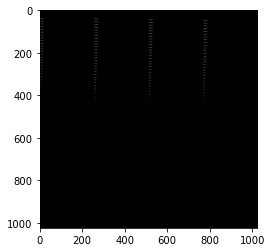

In [29]:
# But nothing can be seen by human eyes after the resizing.
plt.imshow(img, cmap = 'gray')
plt.show()

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [31]:
class RSNA_Dataset(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_2022_path + '/' + str(self.img_data.loc[index, 'patient_id']) + '/' + str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True) # for DICOM data
        image = ds.pixel_array.astype(np.float32)
        # The data augmentation process begins.
        # Convert to PIL image.
        image = Image.fromarray(image)
        # random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size = (256, 256))
        image = transforms.functional.crop(image, i, j, h, w)
        # random horizontal flipping
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
        # Convert back to NumPy array
        image = np.array(image)
        # The data augmentation process ends. It can be cut for validation data set.
        # resize
        image = np.resize(image, (300, 300))
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [32]:
dataset = RSNA_Dataset(DF_train, RSNA_2022_path, transform)

In [33]:
len(dataset)

2316

In [34]:
x, t = dataset[0]

In [35]:
x

tensor([[[1887., 2187., 1999.,  ..., 2685., 2695., 2529.],
         [2373., 2181., 2095.,  ..., 1895., 1647., 1841.],
         [1491., 2089., 1879.,  ..., 1753., 1661., 1757.],
         ...,
         [2295., 2543., 1915.,  ..., 2209., 1727., 2251.],
         [2409., 1923., 2019.,  ..., 2063., 1683., 1741.],
         [2163., 1911., 2191.,  ..., 2877., 3425., 2911.]]])

In [36]:
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([1, 300, 300]))

In [37]:
t

tensor(0)

In [38]:
train, Val = torch.utils.data.random_split(dataset = dataset, lengths = [1800, 516], generator = torch.Generator().manual_seed(42))

In [39]:
len(train), len(Val)

(1800, 516)

In [40]:
class RSNA_Valset(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_2022_path + '/' + str(self.img_data.loc[index, 'patient_id']) + '/' + str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True) # for DICOM data
        image = ds.pixel_array.astype(np.float32)
        # resize
        image = np.resize(image, (300, 300))
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [41]:
dataset_val = RSNA_Valset(DF_train, RSNA_2022_path, transform)

In [42]:
len(dataset_val)

2316

In [43]:
Train, val = torch.utils.data.random_split(dataset = dataset_val, lengths = [1800, 516], generator = torch.Generator().manual_seed(42))

In [44]:
len(Train), len(val)

(1800, 516)

**They are what we exactly need!**

In [45]:
# They are what we exactly need!
len(train), len(val)

(1800, 516)

In [46]:
# Check that the dataset is balanced with not-malignant and malignant cases.
can = 0
for i in range(len(val)):
    x, t = val[i]
    if t == 1:
        can += 1
print(can / len(val))        

0.5038759689922481


In [47]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 128)

In [48]:
class RSNA_Dataset_Visual(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_2022_path + '/' + str(self.img_data.loc[index, 'patient_id']) + '/' + str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True)
        image = ds.pixel_array.astype(np.float32)
        #image = np.resize(image, (300, 300)) # no risize
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [49]:
dataset_visual = RSNA_Dataset_Visual(DF_train, RSNA_2022_path, transform)

In [50]:
# Use the same random seed to create the same dataset as before except for the resizing. 
train_visual, val_visual = torch.utils.data.random_split(dataset = dataset_visual, lengths = [1800, 516], generator = torch.Generator().manual_seed(42))

In [51]:
def img_display(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    #npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

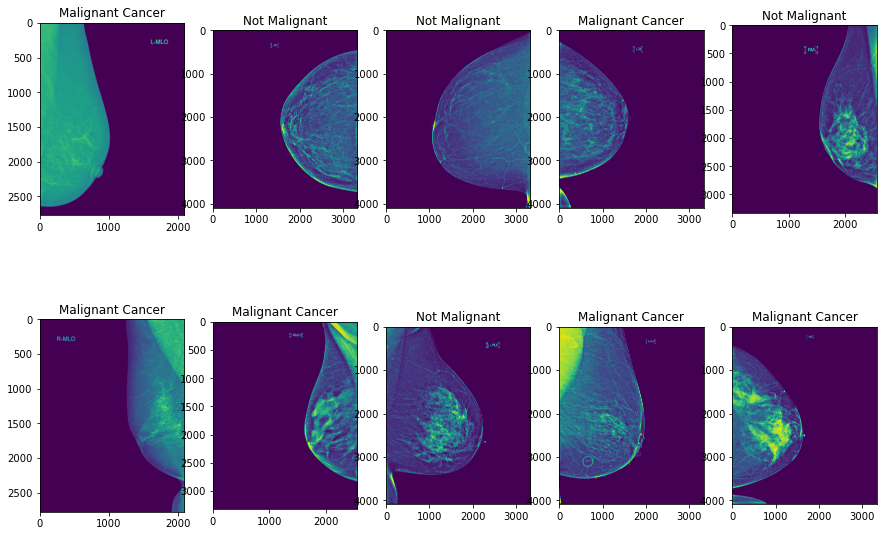

In [52]:
# Get some training images.
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = train_visual[i]
        ax.imshow(img_display(image).squeeze(0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3,stride = 2,padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3,stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3,stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3,stride = 2, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64 * 5 * 5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.logsigmoid(self.fc3(x))
        return x

In [54]:
#model = Net() # On CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device) # On GPU
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [55]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor = 0.1, total_iters = 8)

In [56]:
n_epochs = 6
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
# training
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    scheduler.step(epoch)
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device) # on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        pred = torch.sigmoid(outputs)
        target = target_.unsqueeze(1).float()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        pred = pred > 0.40 # normally 0.5
        accuracy = (target == pred).sum().item() / target.size(0)

        if (batch_idx) % 3 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * accuracy)
    train_loss.append(running_loss / total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * accuracy):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
# validation
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader):
            data_t, target_t = data_t.to(device), target_t.to(device) # on GPU
            outputs_t = model(data_t)
            pred_t = torch.sigmoid(outputs_t)
            target_t = target_t.unsqueeze(1).float()
            loss_t = criterion(pred_t, target_t)
            batch_loss += loss_t.item()
            pred_t = pred_t > 0.40 # normally 0.5
            accuracy_t = (target_t == pred_t).sum().item() / target_t.size(0)
        val_acc.append(100 * accuracy_t)
        val_loss.append(batch_loss / len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * accuracy_t):.4f}\n')
        # Saving the best weight. 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'cancer_classification.pt')
            print('Detected network improvement, saving current model')
    scheduler.step()
    model.train()

Epoch 1



/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Epoch [1/6], Step [0/14], Loss: 0.7222
Epoch [1/6], Step [3/14], Loss: 0.7978
Epoch [1/6], Step [6/14], Loss: 0.7051
Epoch [1/6], Step [9/14], Loss: 0.7133
Epoch [1/6], Step [12/14], Loss: 0.7104

train loss: 0.7749, train acc: 44.5312
validation loss: 0.7646, validation acc: 50.0000

Detected network improvement, saving current model
Epoch 2

Epoch [2/6], Step [0/14], Loss: 0.8581
Epoch [2/6], Step [3/14], Loss: 0.7583
Epoch [2/6], Step [6/14], Loss: 1.0999
Epoch [2/6], Step [9/14], Loss: 0.6987
Epoch [2/6], Step [12/14], Loss: 0.7866

train loss: 0.7748, train acc: 57.8125
validation loss: 0.7287, validation acc: 50.0000

Detected network improvement, saving current model
Epoch 3

Epoch [3/6], Step [0/14], Loss: 0.7080
Epoch [3/6], Step [3/14], Loss: 0.7362
Epoch [3/6], Step [6/14], Loss: 0.6903
Epoch [3/6], Step [9/14], Loss: 0.7313
Epoch [3/6], Step [12/14], Loss: 0.7325

train loss: 0.7572, train acc: 50.0000
validation loss: 0.7164, validation acc: 0.0000

Detected network improv

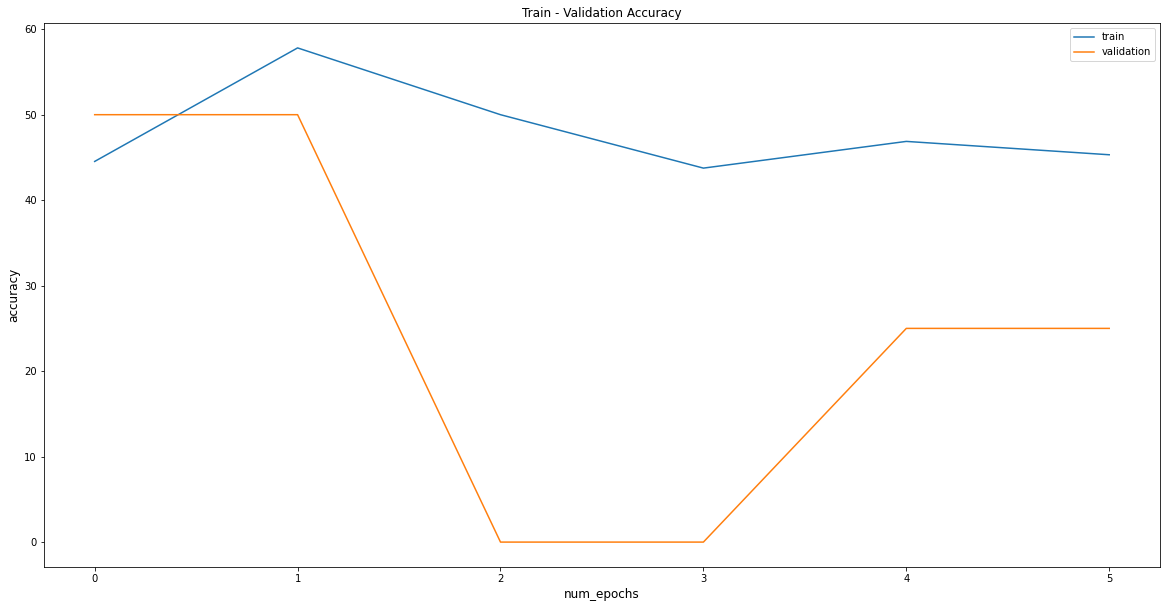

In [57]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label = 'train')
plt.plot(val_acc, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.legend(loc = 'best')

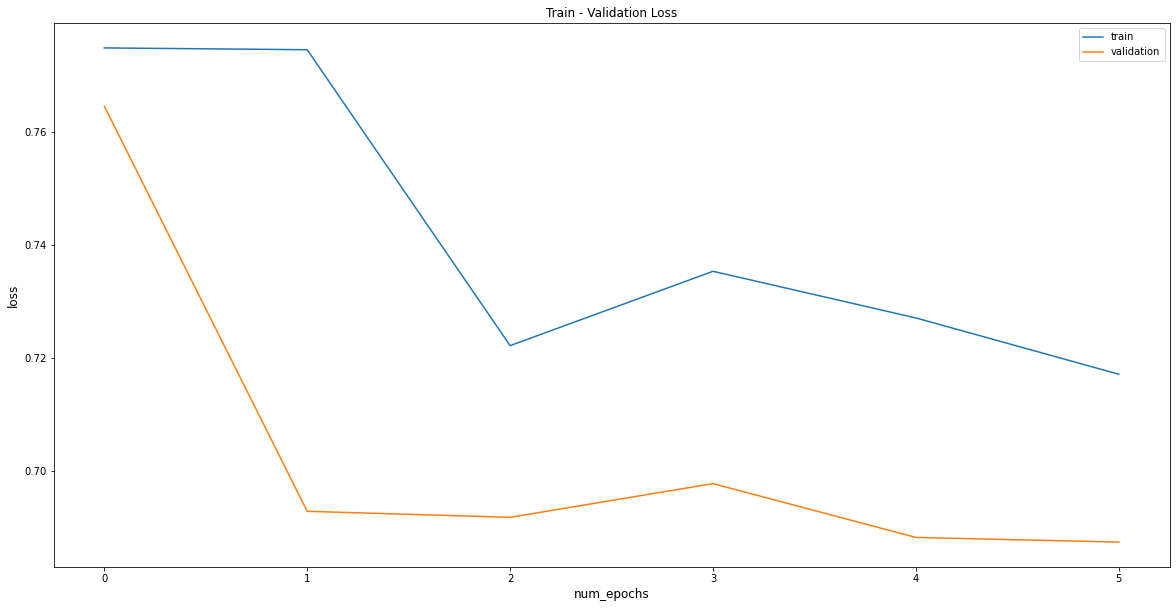

In [58]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Loss")
plt.plot(train_loss, label = 'train')
plt.plot(val_loss, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('loss', fontsize = 12)
plt.legend(loc = 'best')

In [59]:
# importing trained network with better loss of validation
model.load_state_dict(torch.load('cancer_classification.pt'))

<All keys matched successfully>

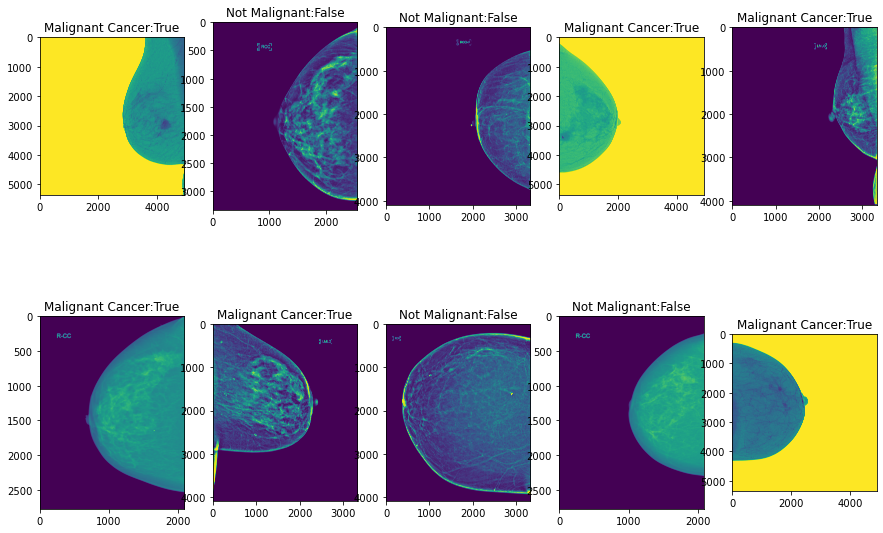

In [60]:
# "True" and "False" mean that the prediction by the model is correct or wrong, respectively.
model = model.cpu() # CPU
dataiter = iter(val_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        model.eval()
        image_visual, label_visual = val_visual[i]
        image, label = images[i], labels[i]
        ax.imshow(img_display(image_visual.squeeze(0))) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = torch.sigmoid(output_)
        if output_.item() > 0.40: # normally 0.5
            k = (label.item() == 1)
        else:
            k = (label.item() == 0)
        ax.set_title(str(arthopod_types[label.item()]) + ":" + str(k)) # add label

In [61]:
model = model.cpu() # CPU
model.eval()
y_pred = []
y_true = []

# Iterate over test data.
with torch.no_grad():
    for inputs, labels in val_loader:
            outputs = model(inputs) # Feed Network.
            outputs = torch.sigmoid(outputs)

            for i in range(len(outputs)):
                output = outputs[i]            
                if output.item() > 0.40: # normally 0.5
                    y_pred.append(int(1)) # Save prediction.
                else:
                    y_pred.append(int(0)) # Save prediction.

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save truth.

# constant for classes
classes = ('Not Malignant', 'Malignant Cancer')

In [62]:
# Build confusion matrix.
cm = confusion_matrix(y_true, y_pred)

Confusion Matrix


Text(69.0, 0.5, 'Predicted')

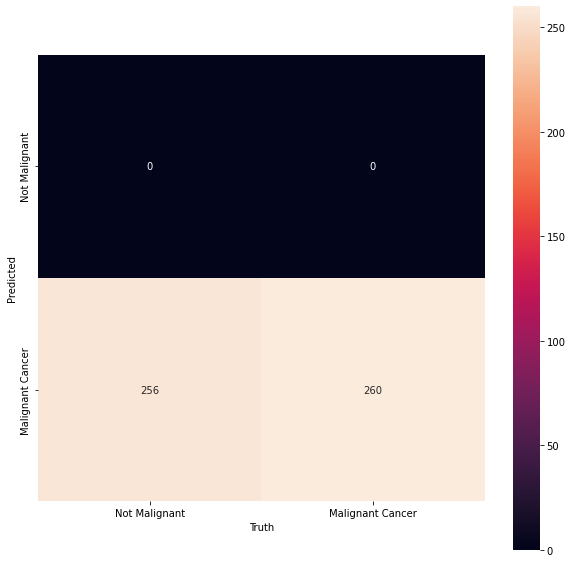

In [63]:
target_name = {'Not Malignant': 0, 'Malignant Cancer': 1}
print('Confusion Matrix')
plt.figure(figsize = (10, 10))
_ = sns.heatmap(cm.T, annot = True, fmt = 'd', cbar = True, square = True, xticklabels = target_name.keys(),
             yticklabels = target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

In [64]:
RSNA_test_path = '/kaggle/input/rsna-breast-cancer-detection/test_images'

In [65]:
df_test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [66]:
class RSNA_Testset(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_test_path + '/' + str(self.img_data.loc[index, 'patient_id']) + '/' + str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True)
        image = ds.pixel_array.astype(np.float32)
        image = np.resize(image, (300, 300))
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        #label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image#, label

In [67]:
testset = RSNA_Testset(df_test, RSNA_test_path, transform)

## Without data loader

In [68]:
model = model.to(device) # On GPU
model.eval()
cancer = []
with torch.no_grad():
    for i in range(len(testset)):
        out = testset[i].unsqueeze_(0)
        out = out.to(device)
        out = model(out)
        out = torch.sigmoid(out)
        cancer.append(out.item())
cancer

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[0.4516933262348175,
 0.41572457551956177,
 0.45682209730148315,
 0.44863981008529663]

## With data loader

In [69]:
# Load the test set.
testset = RSNA_Testset(df_test, RSNA_test_path, transform)

# Create a DataLoader for the test set.
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle = False)

# Move the model to the GPU (if available).
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Put the model in evaluation mode.
model.eval()

# Make predictions on the test set.
cancer = []
with torch.no_grad():
    for images in testloader:
        # Move the batch of images to the GPU (if available).
        images = images.to(device)

        # Pass the batch of images through the model to get the predicted cancer probabilities.
        out = model(images)

        # Apply a sigmoid function to get a probability between 0 and 1.
        out = torch.sigmoid(out)

        # Add the predicted probabilities to the list
        cancer.extend(out.cpu().numpy())
        
        cancer_probs = np.concatenate(cancer)
        
        cancer = [x[0] for x in cancer]

# Print the predicted probabilities.
print(cancer)

[0.45169333, 0.41572458, 0.4568221, 0.4486398]


In [70]:
df_test['cancer'] = cancer
df_test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10008,736471439,L,MLO,81,0,21,10008_L,0.451693
1,2,10008,1591370361,L,CC,81,0,21,10008_L,0.415725
2,2,10008,68070693,R,MLO,81,0,21,10008_R,0.456822
3,2,10008,361203119,R,CC,81,0,21,10008_R,0.448640


In [71]:
submission = df_test.loc[:, 'prediction_id':'cancer']
submission

,prediction_id,cancer
0,10008_L,0.451693
1,10008_L,0.415725
2,10008_R,0.456822
3,10008_R,0.448640


In [72]:
# Choose mean, max, min, or something else.
submission = submission.groupby('prediction_id').mean().reset_index()
submission

,prediction_id,cancer
0,10008_L,0.433709
1,10008_R,0.452731


In [73]:
submission = pd.DataFrame(data = {'prediction_id': df_test['prediction_id'], 'cancer': cancer})
submission

,prediction_id,cancer
0,10008_L,0.451693
1,10008_L,0.415725
2,10008_R,0.456822
3,10008_R,0.448640


## Attention
I prefer max() to mean() or min(), because it is possible that **cancer can be observed from one view (high score) and cannot be observed from the other view (low score)**. If cancer is positive from one view, this case should be positive regardless of the other view.

In [74]:
submission = submission.groupby('prediction_id').max().reset_index()
submission

,prediction_id,cancer
0,10008_L,0.451693
1,10008_R,0.456822


In [75]:
submission.to_csv('submission.csv', index = False)